In [1]:
import ray

In [2]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()


2023-10-16 22:44:30,241	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.16
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


In [3]:
ray.cluster_resources()

{'memory': 836940596.0,
 'object_store_memory': 418470297.0,
 'node:127.0.0.1': 1.0,
 'GPU': 1.0,
 'node:__internal_head__': 1.0,
 'CPU': 8.0}

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

In [5]:
# Data ingestion
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [6]:
df['tag'].value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [7]:
# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)


In [8]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

In [9]:
# Most common tags
all_tags = Counter(df['tag'])
all_tags.most_common()


[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

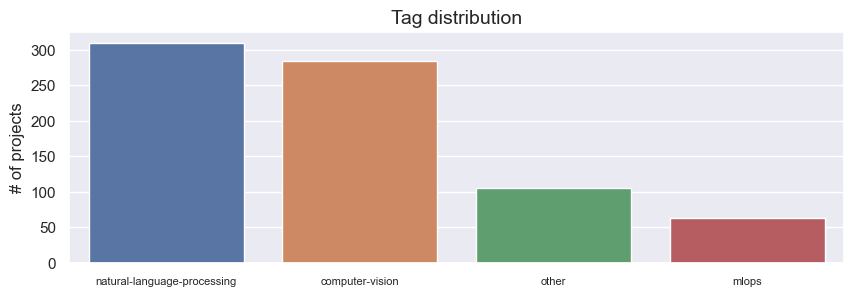

In [10]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=8)
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()

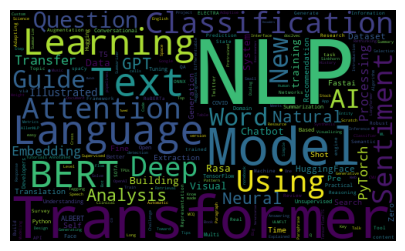

In [11]:
tag = "natural-language-processing"
plt.figure(figsize=(10,3))
subset = df[df['tag'] == tag]
text = subset['title'].values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color= 'black', collocations= False,
    width = 500, height= 300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)


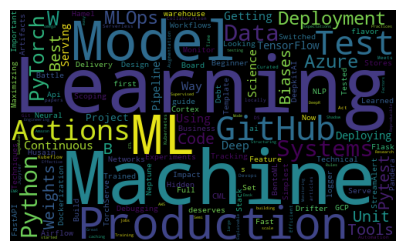

In [12]:
tag = "mlops"
plt.figure(figsize=(10,3))
subset = df[df['tag'] == tag]
text = subset['title'].values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color= 'black', collocations= False,
    width = 500, height= 300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

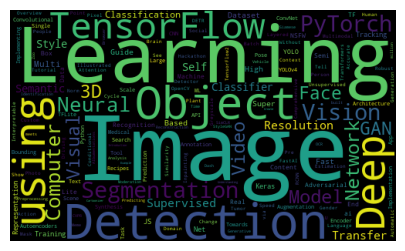

In [13]:
tag = "computer-vision"
plt.figure(figsize=(10,3))
subset = df[df['tag'] == tag]
text = subset['title'].values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color= 'black', collocations= False,
    width = 500, height= 300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

In [14]:
## Preprocessing


In [15]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [16]:
# Feature engineering
df["text"] = df.title + " " + df.description

In [17]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to C:\Users\Prathamesh
[nltk_data]     Chaudhari\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [18]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links
    
    return text

In [19]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [20]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


In [21]:
# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [22]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [23]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [24]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

In [25]:
import numpy as np
from transformers import BertTokenizer

In [26]:
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

(…)_scivocab_uncased/resolve/main/vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

(…)civocab_uncased/resolve/main/config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [27]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [28]:
# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2], dtype=int64)}

In [29]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [30]:
# Apply
#preprocess(df=train_df, class_to_index=class_to_index)


In [31]:
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

2023-10-16 22:45:30,564	INFO read_api.py:406 -- To satisfy the requested parallelism of 16, each read task output is split into 16 smaller blocks.
2023-10-16 22:45:30,755	INFO dataset.py:2380 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2023-10-16 22:45:30,761	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-10-16 22:45:30,764	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-10-16 22:45:30,767	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 428,
  'created_on': datetime.datetime(2020, 4, 10, 4, 57, 53),
  'title': 'AiLight: Automatic  Highlighting Using BERT',
  'description': 'Automatically highlight pdfs using BERT embeddings and clustering.\nhttps://anishthite.github.io/ailight',
  'tag': 'natural-language-processing'}]

In [32]:
import sys
sys.path.append("..")
from madewithml.data import stratify_split

In [33]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2023-10-16 22:45:37,295	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-10-16 22:45:37,298	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-10-16 22:45:37,299	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [34]:
# Mapping
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2023-10-16 22:45:38,068	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-10-16 22:45:38,069	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-10-16 22:45:38,071	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2023-10-16 22:45:46,464	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-10-16 22:45:46,471	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-10-16 22:45:46,473	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

In [35]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(
  preprocess,
  fn_kwargs={"class_to_index": class_to_index},
  batch_format="pandas")
sample_ds.show(1)

2023-10-16 22:45:50,259	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2023-10-16 22:45:50,262	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-10-16 22:45:50,264	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

{'ids': array([  102,  2158,  2556,  6021,  1968, 13749,  1904, 12662, 14288,
       30111,  9999,   164,  2040,  1968, 13749,  1904,  2556,  6021,
        6076,  1516, 24660, 30131,   103,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'targets': 0}


## Training

In [40]:
import os
import random
import torch
from ray.data.preprocessor import Preprocessor

In [41]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [42]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [44]:
class CustomPreprocessor():
    """Custom preprocessor class."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        
    def fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        return self
    
    def transform(self, ds):
        return ds.map_batches(
            preprocess, 
            fn_kwargs={"class_to_index": self.class_to_index}, 
            batch_format="pandas")

### Model

In [45]:
import torch.nn as nn
from transformers import BertModel

In [46]:
# Pretrained LLM
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
# Sample
text = "Transfer learning with transformers for text classification."
batch = tokenizer([text], return_tensors="np", padding="longest")
batch = {k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
np.shape(seq), np.shape(pool)

(torch.Size([1, 10, 768]), torch.Size([1, 768]))

In [ ]:
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout_p = dropout_p
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z
    
    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(batch)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred
    
    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z, dim=1).cpu().numpy()
        return y_probs
    
    def save(self, dp):
        with open(Path(dp, "args.json"), "w") as fp:
            contents = {
                "dropout_p": self.dropout_p,
                "embedding_dim": self.embedding_dim,
                "num_classes": self.num_classes,
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
        torch.save(self.state_dict(), os.path.join(dp, "model.pt"))

    @classmethod
    def load(cls, args_fp, state_dict_fp):
        with open(args_fp, "r") as fp:
            kwargs = json.load(fp=fp)
        llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
        model = cls(llm=llm, **kwargs)
        model.load_state_dict(torch.load(state_dict_fp, map_location=torch.device("cpu")))
        return model